### PHASE 1

## Step 1: Install Required Libraries

In [ ]:
pip install pandas sqlalchemy psycopg2



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Step 2: Create Database Connection

In [1]:
from sqlalchemy import create_engine
import pandas as pd

#  My PostgreSQL credentials
username = 'postgres'         # default username for PostgreSQL
password = 'root'    # replace this with your actual password
host = 'localhost'            # PostgreSQL is hosted locally
port = '5432'                 # default port
database = 'ecommerce_data'   # your database name (you already created it)

# 🔗 Creating the connection string
connection_string = f"postgresql+psycopg2://{username}:{password}@{host}:{port}/{database}"

# 🚀 Create engine
engine = create_engine(connection_string)

# ✅ Test connection
try:
    with engine.connect() as conn:
        print("✅ Connected to PostgreSQL successfully!")
except Exception as e:
    print("❌ Connection failed:", e)

✅ Connected to PostgreSQL successfully!


### PHASE 2


### Step 1: Import Libraries & Set Up

In [2]:
# Data manipulation
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set styles for better plots
sns.set(style="whitegrid")

# Ignore unnecessary warnings
import warnings
warnings.filterwarnings("ignore")

## STEP 2: Create PostgreSQL Connection

In [4]:
# Database credentials
db_user = 'postgres'
db_password = 'root'  # replace this
db_host = 'localhost'
db_port = '5432'
db_name = 'ecommerce_data'

# Create connection
engine = create_engine(f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}')


## STEP 3: Load CSV Files into Pandas

In [5]:
# ✅ STEP 1: Import required libraries
import pandas as pd
import os


In [6]:
# ✅ STEP 2: Define the correct data folder path (raw string to avoid backslash issues)
data_path = r"C:\Users\lenovo\Desktop\instacart-recommender-system\data"


In [7]:
import pandas as pd
import os

# Define path to the data
data_path = "../data"  # or use full path if needed

# Load CSVs
aisles = pd.read_csv(os.path.join(data_path, "aisles.csv"))
departments = pd.read_csv(os.path.join(data_path, "departments.csv"))
products = pd.read_csv(os.path.join(data_path, "products.csv"))
orders = pd.read_csv(os.path.join(data_path, "orders.csv"))
order_products_prior = pd.read_csv(os.path.join(data_path, "order_products__prior.csv"))
order_products_train = pd.read_csv(os.path.join(data_path, "order_products__train.csv"))

print("✅ Data loaded successfully.")


✅ Data loaded successfully.


##  Step 3: View Sample Data from Each File

In [8]:
aisles.head()
departments.head()
products.head()
orders.head()
order_products_prior.head()
order_products_train.head()


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


## Step 4: Memory Optimization (because dataset is huge)

In [9]:
def reduce_memory(df):
    """ Reduce memory usage of a DataFrame by downcasting numeric types """
    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > -128 and c_max < 127:
                    df[col] = df[col].astype('int8')
                elif c_min > -32768 and c_max < 32767:
                    df[col] = df[col].astype('int16')
                else:
                    df[col] = df[col].astype('int32')
            else:
                df[col] = df[col].astype('float32')
    return df

# Apply to large files
order_products_prior = reduce_memory(order_products_prior)
order_products_train = reduce_memory(order_products_train)
orders = reduce_memory(orders)

print("✅ Memory reduced.")


✅ Memory reduced.


## Step 4: Exploratory Data Analysis (EDA)

## Step 1: How Many Orders Do We Have?

In [10]:
print("Total orders:", orders.shape[0])
print("Unique users:", orders['user_id'].nunique())


Total orders: 3421083
Unique users: 206209


## Step 2: Evaluate Set Breakdown (prior, train, test)

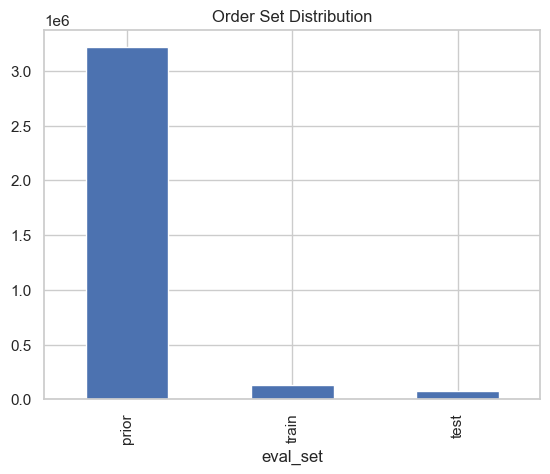

In [11]:
orders['eval_set'].value_counts().plot(kind='bar', title='Order Set Distribution');


## Step 3: Most Ordered Products (from order_products__prior.csv)

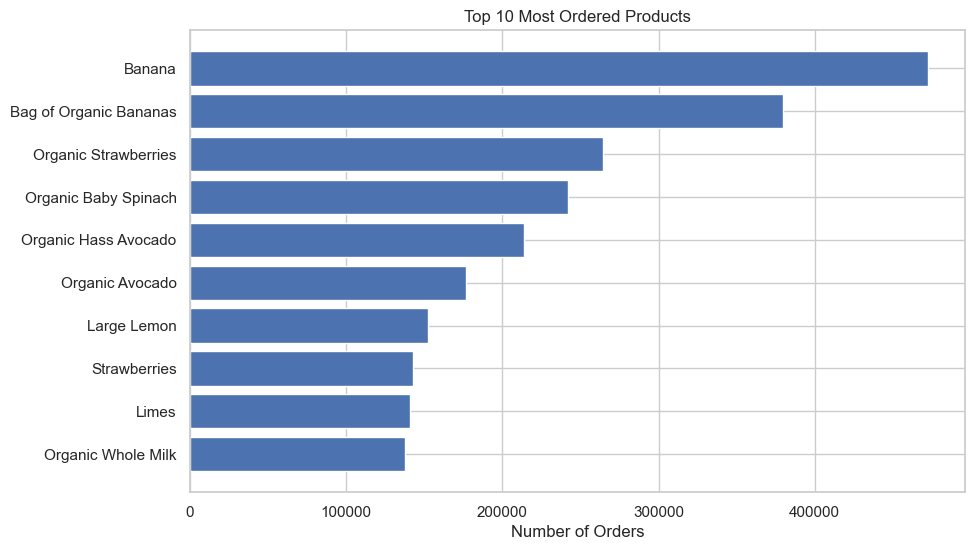

In [12]:
import matplotlib.pyplot as plt

# Step 1: Get top 10 most ordered product IDs
top_product_counts = order_products_prior['product_id'].value_counts().head(10)

# Step 2: Convert to DataFrame and rename properly
top_products = pd.DataFrame({
    'product_id': top_product_counts.index,
    'count': top_product_counts.values
})

# Step 3: Merge with product names
top_products = top_products.merge(products[['product_id', 'product_name']], on='product_id', how='left')

# Step 4: Plot
plt.figure(figsize=(10, 6))
plt.barh(top_products['product_name'], top_products['count'])
plt.title("Top 10 Most Ordered Products")
plt.xlabel("Number of Orders")
plt.gca().invert_yaxis()
plt.show()


## Step 4: Reorder Ratio


In [13]:
reorder_ratio = order_products_prior['reordered'].mean()
print(f"Average reorder ratio: {reorder_ratio:.2f}")


Average reorder ratio: 0.59


## Step 5: Add-to-Cart Position Distribution

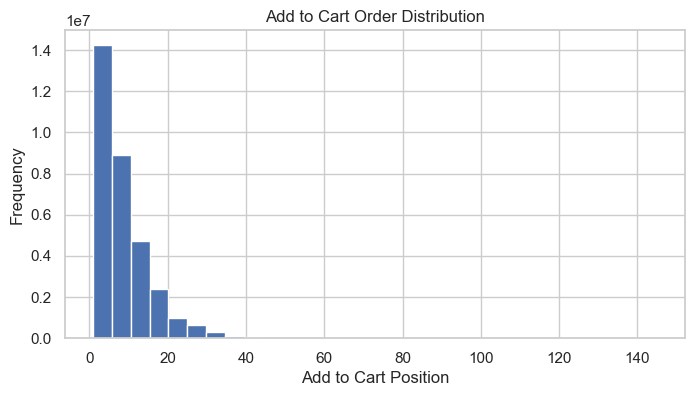

In [14]:
order_products_prior['add_to_cart_order'].hist(bins=30, figsize=(8, 4))
plt.title("Add to Cart Order Distribution")
plt.xlabel("Add to Cart Position")
plt.ylabel("Frequency")
plt.show()


## Step 6: Number of Products Per Order

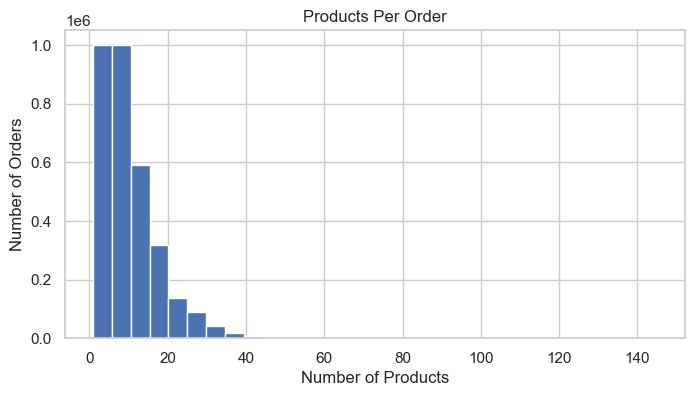

In [15]:
products_per_order = order_products_prior.groupby('order_id').size()
products_per_order.hist(bins=30, figsize=(8, 4))
plt.title("Products Per Order")
plt.xlabel("Number of Products")
plt.ylabel("Number of Orders")
plt.show()


## Step 7: Most Popular Aisles and Departments

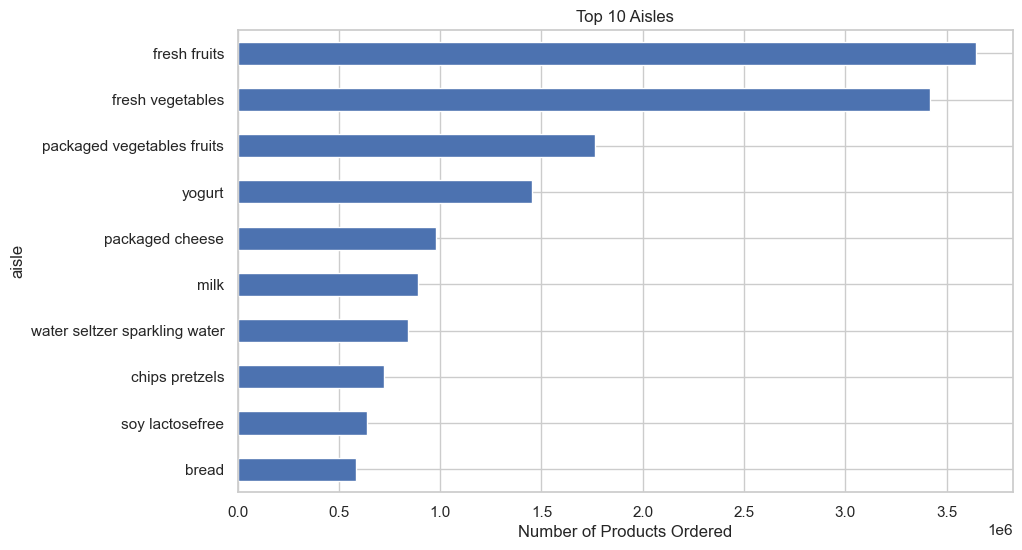

In [16]:
# Merge products with aisles and departments
product_info = products.merge(aisles, on='aisle_id').merge(departments, on='department_id')

# Count most popular aisles
popular_aisles = order_products_prior.merge(product_info, on='product_id')['aisle'].value_counts().head(10)

# Plot
plt.figure(figsize=(10, 6))
popular_aisles.plot(kind='barh')
plt.title("Top 10 Aisles")
plt.xlabel("Number of Products Ordered")
plt.gca().invert_yaxis()
plt.show()


## PHASE 3

##  Build a Baseline Recommender System

## Step 1: Count Top-N Most Ordered Products

In [17]:
# Count how many times each product was ordered
product_order_counts = order_products_prior['product_id'].value_counts().reset_index()
product_order_counts.columns = ['product_id', 'order_count']  # Rename columns

# Merge with product names
top_products = product_order_counts.merge(products[['product_id', 'product_name']], on='product_id', how='left')

# Show Top-N
N = 10
top_N = top_products.head(N)

print("🎯 Top", N, "Most Ordered Products:")
print(top_N[['product_name', 'order_count']])


🎯 Top 10 Most Ordered Products:
             product_name  order_count
0                  Banana       472565
1  Bag of Organic Bananas       379450
2    Organic Strawberries       264683
3    Organic Baby Spinach       241921
4    Organic Hass Avocado       213584
5         Organic Avocado       176815
6             Large Lemon       152657
7            Strawberries       142951
8                   Limes       140627
9      Organic Whole Milk       137905


## Step 2: Create a Recommender Function

In [18]:
def recommend_top_n_products(n=10):
    top_n = top_products.head(n)
    return top_n[['product_id', 'product_name', 'order_count']]

# Example: Recommend top 10
recommendations = recommend_top_n_products(10)
print("Top 10 Recommended Products:\n", recommendations)


Top 10 Recommended Products:
    product_id            product_name  order_count
0       24852                  Banana       472565
1       13176  Bag of Organic Bananas       379450
2       21137    Organic Strawberries       264683
3       21903    Organic Baby Spinach       241921
4       47209    Organic Hass Avocado       213584
5       47766         Organic Avocado       176815
6       47626             Large Lemon       152657
7       16797            Strawberries       142951
8       26209                   Limes       140627
9       27845      Organic Whole Milk       137905


## Step 3: Visualize the Recommendations 

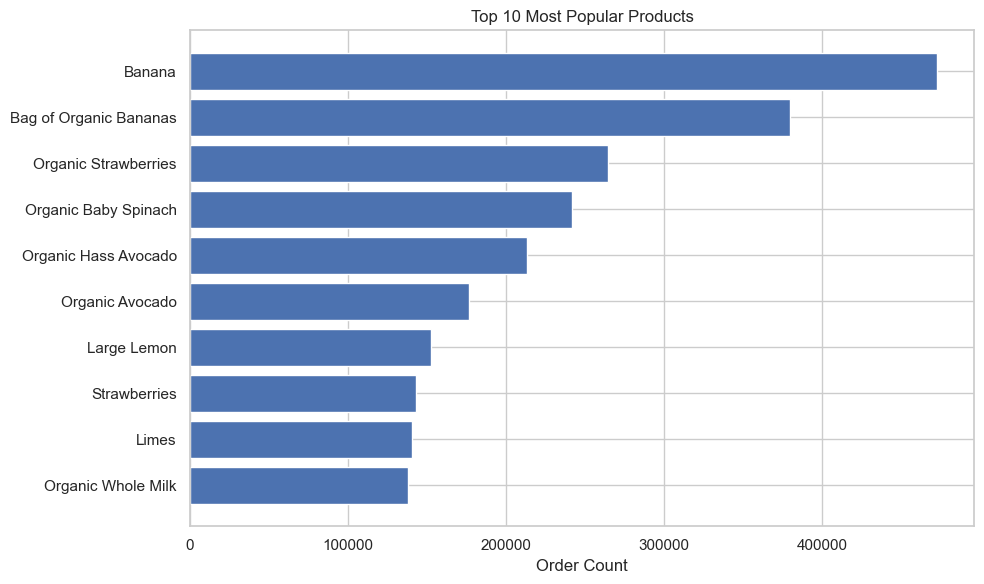

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(top_N['product_name'][::-1], top_N['order_count'][::-1])
plt.xlabel('Order Count')
plt.title('Top 10 Most Popular Products')
plt.tight_layout()
plt.show()


## Step 4: Save Recommendations

In [20]:
# Save top-N recommendations to CSV (optional)
top_N.to_csv('top_n_recommendations.csv', index=False)
print("✅ Top-N recommendations saved to 'top_n_recommendations.csv'")


✅ Top-N recommendations saved to 'top_n_recommendations.csv'


## PHASE 4

##  Build a Personalized Recommender System

Step 1: User-Based Collaborative Filtering (Memory-Based)

Step 2: Item-Item Collaborative Filtering

 ## Step 1: User-Based Collaborative Filtering (Memory-Based)

## 5.1: Create a User-Product Matrix

In [ ]:
# Ensure user_id is available in order_products_prior
order_products_prior = order_products_prior.merge(
    orders[['order_id', 'user_id']],
    on='order_id',
    how='left'
)

# Create the user–product interaction matrix
user_product_matrix = order_products_prior.pivot_table(
    index='user_id',
    columns='product_id',
    values='reordered',  # 1 if reordered, NaN otherwise
    fill_value=0
)

user_product_matrix.head()


In [22]:
import pandas as pd
from scipy.sparse import coo_matrix

# Step 1: Load datasets
orders = pd.read_csv(r"C:\Users\lenovo\Desktop\instacart-recommender-system\data\orders.csv")
order_products_prior = pd.read_csv(r"C:\Users\lenovo\Desktop\instacart-recommender-system\data\order_products__prior.csv")

# Step 2: Keep only "prior" orders
orders_prior = orders[orders['eval_set'] == 'prior']

# Step 3: Merge orders with prior products
user_orders_prior = pd.merge(
    order_products_prior[['order_id', 'product_id', 'reordered']],
    orders_prior[['order_id', 'user_id']],
    on="order_id",
    how="left"
)

# Step 4: Encode users and products as indices
user_ids = user_orders_prior['user_id'].astype("category")
product_ids = user_orders_prior['product_id'].astype("category")

# Step 5: Build sparse user-product matrix (COO format → CSR)
user_product_sparse = coo_matrix(
    (user_orders_prior['reordered'].astype(int),
     (user_ids.cat.codes, product_ids.cat.codes))
).tocsr()

print("✅ Sparse matrix created successfully!")
print(f"Shape (users x products): {user_product_sparse.shape}")
print(f"Memory usage (approx): {user_product_sparse.data.nbytes / 1024**2:.2f} MB")


✅ Sparse matrix created successfully!
Shape (users x products): (206209, 49677)
Memory usage (approx): 101.53 MB


In [24]:
# 1) Quick variable check
for name in ['order_products_prior', 'orders', 'products']:
    print(name, 'in memory =>', name in globals())


order_products_prior in memory => True
orders in memory => True
products in memory => True


In [25]:
import os
import pandas as pd

data_path = r"C:\Users\lenovo\Desktop\instacart-recommender-system\data"  # change if needed
print("data_path:", data_path)
for f in os.listdir(data_path):
    print("-", f)

# dtypes to reduce memory usage
dtypes_prior = {'order_id': 'int32', 'product_id': 'int32', 'add_to_cart_order': 'int16', 'reordered': 'int8'}
dtypes_orders = {'order_id': 'int32', 'user_id': 'int32', 'eval_set': 'object',
                 'order_number': 'int16', 'order_dow': 'int8', 'order_hour_of_day': 'int8',
                 'days_since_prior_order': 'float32'}
dtypes_products = {'product_id': 'int32', 'product_name': 'object', 'aisle_id': 'int16', 'department_id': 'int16'}

# load
order_products_prior = pd.read_csv(os.path.join(data_path, "order_products__prior.csv"), dtype=dtypes_prior)
orders                 = pd.read_csv(os.path.join(data_path, "orders.csv"), dtype=dtypes_orders)
products               = pd.read_csv(os.path.join(data_path, "products.csv"), dtype=dtypes_products)

# quick checks
print("order_products_prior rows:", len(order_products_prior))
print("orders rows:", len(orders))
print("products rows:", len(products))
print("Columns (prior):", order_products_prior.columns.tolist())
print("Columns (orders):", orders.columns.tolist())
print("Columns (products):", products.columns.tolist())


data_path: C:\Users\lenovo\Desktop\instacart-recommender-system\data
- aisles.csv
- departments.csv
- orders.csv
- order_products__prior.csv
- order_products__train.csv
- products.csv
order_products_prior rows: 32434489
orders rows: 3421083
products rows: 49688
Columns (prior): ['order_id', 'product_id', 'add_to_cart_order', 'reordered']
Columns (orders): ['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']
Columns (products): ['product_id', 'product_name', 'aisle_id', 'department_id']


In [26]:
# 3) Merge user_id into order_products_prior
order_products_prior = order_products_prior.merge(
    orders[['order_id', 'user_id']],
    on='order_id',
    how='left'
)

# verify merge
print("Columns after merge:", order_products_prior.columns.tolist())
print("Null user_id count:", order_products_prior['user_id'].isnull().sum())


Columns after merge: ['order_id', 'product_id', 'add_to_cart_order', 'reordered', 'user_id']
Null user_id count: 0


In [27]:
# 4) Pick top-K popular products to compute similarities for
K = 2000   # try 2000 first; if you have memory, increase. For testing you can use K=500
top_product_ids = order_products_prior['product_id'].value_counts().head(K).index.tolist()
len(top_product_ids)


2000

In [28]:
from scipy.sparse import csr_matrix
import numpy as np

# 5.1) Filter rows to only the top-K products
subset = order_products_prior[order_products_prior['product_id'].isin(top_product_ids)].copy()
print("Subset rows (top-K):", len(subset))

# 5.2) Build unique user list (only users who appear in this subset)
users = subset['user_id'].unique()
n_users = users.shape[0]
n_products = len(top_product_ids)
print("n_users (subset):", n_users, "n_products (K):", n_products)

# 5.3) Create mapping dicts
user_to_idx = {uid: i for i, uid in enumerate(users)}
prod_to_idx = {pid: j for j, pid in enumerate(top_product_ids)}
idx_to_prod = {j: pid for pid, j in prod_to_idx.items()}

# 5.4) Prepare rows, cols, data for CSR matrix
rows = subset['user_id'].map(user_to_idx).to_numpy()
cols = subset['product_id'].map(prod_to_idx).to_numpy()
# Use 'reordered' or 1 as interaction. Using 1 treats any purchase equally.
data = (subset['reordered'].fillna(1).astype('int8')).to_numpy()  # fallback to 1 if NaN

# 5.5) Build CSR
user_product_csr = csr_matrix((data, (rows, cols)), shape=(n_users, n_products))
print("CSR shape:", user_product_csr.shape, "nnz:", user_product_csr.nnz)


Subset rows (top-K): 21415760
n_users (subset): 205557 n_products (K): 2000
CSR shape: (205557, 2000) nnz: 7702462


In [29]:
from sklearn.metrics.pairwise import cosine_similarity

# 6) Compute item-item similarity (product-product)
# This returns a dense 2D ndarray of shape (n_products, n_products)
print("Computing cosine similarity for K =", n_products, "products. This may take a while...")
item_similarity = cosine_similarity(user_product_csr.T, dense_output=True)
print("item_similarity shape:", item_similarity.shape)


Computing cosine similarity for K = 2000 products. This may take a while...
item_similarity shape: (2000, 2000)


In [30]:
import numpy as np

def recommend_similar_products(product_id, top_n=10):
    """
    Return list of (product_id, score) for products similar to given product_id
    Only works for product_ids in the top-K set used to build the similarity matrix.
    """
    if product_id not in prod_to_idx:
        return []  # product not in top-K
    idx = prod_to_idx[product_id]
    scores = item_similarity[idx]  # similarity vector to all other products
    # sort descending, skip itself
    top_idx = np.argsort(scores)[::-1][1: top_n + 1]
    results = [(idx_to_prod[i], float(scores[i])) for i in top_idx]
    return results

# Example: use the most popular product
example_pid = top_product_ids[0]
print("Example product id:", example_pid)
recs = recommend_similar_products(example_pid, top_n=10)
recs_df = pd.DataFrame(recs, columns=['product_id', 'score']).merge(products[['product_id','product_name']], on='product_id', how='left')
recs_df


Example product id: 24852


,product_id,score,product_name
0,47766,0.334628,Organic Avocado
1,21137,0.325015,Organic Strawberries
2,47626,0.322305,Large Lemon
3,28204,0.320709,Organic Fuji Apple
4,16797,0.308721,Strawberries
5,21903,0.299317,Organic Baby Spinach
6,49683,0.290881,Cucumber Kirby
7,45066,0.286738,Honeycrisp Apple
8,26209,0.276021,Limes
9,4605,0.271543,Yellow Onions


In [31]:
def recommend_for_user_item_based(user_id, top_n=10):
    # Check user exists in our user_to_idx map
    if user_id not in user_to_idx:
        return []
    u_idx = user_to_idx[user_id]
    # get user interactions vector (sparse)
    user_vector = user_product_csr.getrow(u_idx).toarray().ravel()  # length K
    # compute score for each product = sum(user_vector * item_similarity[:, j])  (dot)
    # Equivalent but efficient with matrix ops:
    scores = user_vector.dot(item_similarity)  # shape (n_products,)
    # mask products the user already has
    bought = user_vector > 0
    scores[bought] = -1  # do not recommend already bought items
    top_idx = np.argsort(scores)[::-1][:top_n]
    return [(idx_to_prod[i], float(scores[i])) for i in top_idx]

# Example: pick a random user from our subset and recommend
example_user = users[0]
user_recs = recommend_for_user_item_based(example_user, top_n=10)
pd.DataFrame(user_recs, columns=['product_id','score']).merge(products[['product_id','product_name']], on='product_id', how='left')


,product_id,score,product_name
0,21903,3.145632,Organic Baby Spinach
1,24964,3.069092,Organic Garlic
2,22935,2.856649,Organic Yellow Onion
3,45007,2.799660,Organic Zucchini
4,26209,2.721654,Limes
5,44359,2.632448,Organic Small Bunch Celery
6,47209,2.578444,Organic Hass Avocado
7,21137,2.517118,Organic Strawberries
8,46667,2.385743,Organic Ginger Root
9,27104,2.336166,Fresh Cauliflower


In [32]:
orders.columns


Index(['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order'],
      dtype='object')

In [33]:
# Rename user_id_x to user_id
if 'user_id_x' in user_orders_prior.columns:
    user_orders_prior = user_orders_prior.rename(columns={'user_id_x': 'user_id'})

# Drop user_id_y if present
if 'user_id_y' in user_orders_prior.columns:
    user_orders_prior = user_orders_prior.drop(columns=['user_id_y'])


In [34]:
import pandas as pd
from scipy.sparse import csr_matrix

# Step 1: Merge prior orders with products
orders_prior = pd.merge(
    order_products_prior,  # from products file
    orders[orders['eval_set'] == 'prior'],
    on='order_id',
    how='inner'
)

print("Columns after merge:", orders_prior.columns.tolist())

# Step 2: Clean user_id columns
if 'user_id_x' in orders_prior.columns:
    orders_prior.rename(columns={'user_id_x': 'user_id'}, inplace=True)
if 'user_id_y' in orders_prior.columns:
    orders_prior.drop(columns=['user_id_y'], inplace=True)

# Step 3: Create sparse user-product interaction matrix
# Assign a value of 1 for reordered/purchased
orders_prior['interaction'] = 1  

# Get unique ids
user_ids = orders_prior['user_id'].unique()
product_ids = orders_prior['product_id'].unique()

# Map to consecutive integer indices
user_id_map = {u: i for i, u in enumerate(user_ids)}
product_id_map = {p: i for i, p in enumerate(product_ids)}

rows = orders_prior['user_id'].map(user_id_map)
cols = orders_prior['product_id'].map(product_id_map)

# Build CSR sparse matrix
user_product_matrix_sparse = csr_matrix(
    (orders_prior['interaction'], (rows, cols)),
    shape=(len(user_ids), len(product_ids))
)

print("Sparse matrix shape:", user_product_matrix_sparse.shape)
print("Memory usage (approx):", user_product_matrix_sparse.data.nbytes / (1024**2), "MB")

# Optional: Convert to pandas DataFrame (careful: can be large)
# user_product_df = pd.DataFrame.sparse.from_spmatrix(
#     user_product_matrix_sparse,
#     index=user_ids,
#     columns=product_ids
# )


Columns after merge: ['order_id', 'product_id', 'add_to_cart_order', 'reordered', 'user_id_x', 'user_id_y', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']
Sparse matrix shape: (206209, 49677)
Memory usage (approx): 101.53162384033203 MB


In [ ]:
pip install implicit


In [ ]:
import pandas as pd
from scipy.sparse import csr_matrix

# Step 1: Load datasets
orders = pd.read_csv(r"C:\Users\lenovo\Desktop\instacart-recommender-system\data\orders.csv")
order_products_prior = pd.read_csv(r"C:\Users\lenovo\Desktop\instacart-recommender-system\data\order_products__prior.csv")

# Step 2: Filter only prior orders
orders_prior = orders[orders['eval_set'] == 'prior']

# Step 3: Merge with prior products
user_orders_prior = pd.merge(order_products_prior, orders_prior, on='order_id', how='left')

# Step 4: Drop duplicate user_id columns if they exist
if 'user_id_x' in user_orders_prior.columns and 'user_id_y' in user_orders_prior.columns:
    user_orders_prior.drop(columns=['user_id_y'], inplace=True)
    user_orders_prior.rename(columns={'user_id_x': 'user_id'}, inplace=True)

# Step 5: Create user-product interaction matrix
user_product_matrix = user_orders_prior.pivot_table(
    index='user_id',
    columns='product_id',
    values='reordered',
    fill_value=0
)

# Step 6: Convert to sparse matrix
user_product_sparse = csr_matrix(user_product_matrix.values)

print(f"Sparse matrix shape: {user_product_sparse.shape}")
print(f"Memory usage (approx): {user_product_sparse.data.nbytes / 1024**2:.2f} MB")


### Phase 4 

## Step 1: Imports & Paths

In [36]:
# --- Imports (lightweight + memory-safe) ---
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix

from sklearn.neighbors import NearestNeighbors  # item-based KNN (cosine)

# --- File path (adjust only if your path changes) ---
DATA_PATH = r"C:\Users\lenovo\Desktop\instacart-recommender-system\data"


## Step 2: Load only the columns we need (faster + less RAM)

Why: we avoid loading unnecessary columns to keep memory stable.

In [37]:
# We only need minimal columns to build interactions
orders = pd.read_csv(
    fr"{DATA_PATH}\orders.csv",
    usecols=["order_id", "user_id", "eval_set"],      # load only what's needed
    dtype={"order_id": np.int32, "user_id": np.int32, "eval_set": "category"}
)

order_products_prior = pd.read_csv(
    fr"{DATA_PATH}\order_products__prior.csv",
    usecols=["order_id", "product_id", "reordered"],  # load only what's needed
    dtype={"order_id": np.int32, "product_id": np.int32, "reordered": np.int8}
)

products = pd.read_csv(
    fr"{DATA_PATH}\products.csv",
    usecols=["product_id", "product_name", "aisle_id", "department_id"],
    dtype={"product_id": np.int32, "product_name": "string",
           "aisle_id": np.int16, "department_id": np.int16}
)

# Keep only historical ("prior") orders
orders_prior = orders[orders["eval_set"] == "prior"][["order_id", "user_id"]]


## Step 3: Merge & build a sparse user×product matrix (no dense pivot!)

Why: COO→CSR avoids a dense pivot table (which caused your MemoryError).

In [38]:
# Merge minimal frames to get (user_id, product_id, reordered)
user_orders_prior = order_products_prior.merge(orders_prior, on="order_id", how="inner")
# Keep only the columns we need going forward
user_orders_prior = user_orders_prior[["user_id", "product_id", "reordered"]]

# Encode ids as categorical to get compact integer codes (safe for sparse matrices)
user_cat = user_orders_prior["user_id"].astype("category")
prod_cat = user_orders_prior["product_id"].astype("category")

# Save mappings for later (index -> original id)
user_index_to_id = user_cat.cat.categories      # pandas Index of unique user_ids
product_index_to_id = prod_cat.cat.categories   # pandas Index of unique product_ids

# Build COO sparse matrix from (row indices, col indices, values) then convert to CSR
rows = user_cat.cat.codes.values                # 0..num_users-1
cols = prod_cat.cat.codes.values                # 0..num_products-1
vals = user_orders_prior["reordered"].astype(np.float32).values  # 1.0 or 0.0

user_product_sparse = coo_matrix((vals, (rows, cols)),
                                 shape=(len(user_index_to_id), len(product_index_to_id))
                                ).tocsr()

print("✅ Sparse matrix ready")
print("Shape (users x products):", user_product_sparse.shape)
print(f"Non-zeros stored: {user_product_sparse.nnz:,}")
print(f"Approx. data memory: {user_product_sparse.data.nbytes/1024**2:.2f} MB")


✅ Sparse matrix ready
Shape (users x products): (206209, 49677)
Non-zeros stored: 13,307,953
Approx. data memory: 50.77 MB


## Step 4: Fit an item-based KNN model on the item–user matrix

Why: This learns which products are “similar” based on having similar buyers.

In [39]:
# For item-based similarity, we need matrix as (items x users)
item_user_sparse = user_product_sparse.T.tocsr()  # transpose: products x users

# KNN with cosine distance (brute force is fine with sparse input and reasonable k)
knn_model = NearestNeighbors(
    n_neighbors=50,         # number of similar items to retrieve per item
    metric="cosine",        # cosine distance (1 - cosine similarity)
    algorithm="brute"       # brute works well for sparse + cosine
)
knn_model.fit(item_user_sparse)

print("✅ KNN item-similarity model fitted")


✅ KNN item-similarity model fitted


## Step 5: Helper lookups (ID ↔ index, names, user history)

In [40]:
# Quick lookup: actual user_id -> row index in user_product_sparse
user_id_to_index = pd.Series(
    index=user_index_to_id,      # original ids as index
    data=np.arange(len(user_index_to_id), dtype=np.int32)  # 0..n-1
)

# Product name lookup (id -> name)
product_name = products.set_index("product_id")["product_name"].to_dict()

def get_user_items(uidx):
    """
    Return the set of product indices the user (by row index) has interacted with.
    """
    row = user_product_sparse[uidx]
    return set(row.indices)  # indices = column (product) indices with nonzero entries


## Step 6: Recommend Top-N products for a given actual user_id

This aggregates nearest-neighbor items of what the user has already bought.

In [41]:
def recommend_for_user(actual_user_id: int, N: int = 10, per_item_neighbors: int = 50):
    """
    Recommend Top-N products for a given actual user_id using item-based KNN.
    - For each product the user has, fetch its k nearest neighbor products.
    - Aggregate neighbor scores across all user products.
    - Exclude already-seen products.
    - Return top N as (product_id, product_name, score).
    """
    # Map actual user_id to internal row index
    if actual_user_id not in user_id_to_index.index:
        raise ValueError(f"user_id {actual_user_id} not found in training data.")
    uidx = int(user_id_to_index.loc[actual_user_id])

    # Items the user already has
    user_items = get_user_items(uidx)
    if not user_items:
        return []

    scores = {}
    # For each item the user has, fetch similar items
    for item_idx in user_items:
        # Query neighbors for this item (returns distances; sim = 1 - distance)
        distances, neighbors = knn_model.kneighbors(
            item_user_sparse[item_idx],
            n_neighbors=per_item_neighbors,
            return_distance=True
        )
        distances = distances.ravel()
        neighbors = neighbors.ravel()

        for dist, nbr in zip(distances, neighbors):
            if nbr in user_items:             # skip items user already has
                continue
            sim = 1.0 - float(dist)           # convert cosine distance -> similarity
            # Aggregate similarity scores (sum)
            scores[nbr] = scores.get(nbr, 0.0) + sim

    # Rank candidate items by score
    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:N]

    # Map internal product indices back to real product_ids + names
    recs = []
    for prod_idx, score in ranked:
        prod_id = int(product_index_to_id[prod_idx])
        name = product_name.get(prod_id, "Unknown product")
        recs.append({"product_id": prod_id, "product_name": name, "score": float(score)})

    return recs


## Step 7: Try it for a sample user (and display nicely)

In [42]:
# Pick the first user in our matrix (you can replace with an actual id from your data)
sample_actual_user_id = int(user_index_to_id[0])
print("Sample actual user_id:", sample_actual_user_id)

sample_recs = recommend_for_user(sample_actual_user_id, N=10, per_item_neighbors=50)
pd.DataFrame(sample_recs)


Sample actual user_id: 1


,product_id,product_name,score
0,6184,Clementines,2.450095
1,37710,Trail Mix,2.046202
2,31651,Extra Fancy Unsalted Mixed Nuts,1.612432
3,45051,Pub Mix,1.556738
4,11759,Organic Simply Naked Pita Chips,1.515447
5,13575,Apples,1.492303
6,41400,Crunchy Oats 'n Honey Granola Bars,1.335974
7,13042,with Crispy Almonds Cereal,1.285044
8,31759,Cherrios Honey Nut,1.277447
9,13424,Almonds,1.156946


In [46]:
# Rebuild a smaller user-product matrix to avoid memory issues
import pandas as pd
from scipy.sparse import csr_matrix

# Choose first 10,000 users
user_subset = user_orders_prior[user_orders_prior['user_id'].isin(
    user_orders_prior['user_id'].unique()[:10000]
)]

# Create pivot table (user_id × product_id)
user_product_matrix_small = user_subset.pivot_table(
    index='user_id',
    columns='product_id',
    values='reordered',
    aggfunc='sum',
    fill_value=0
)

# Convert to sparse
user_product_sparse_small = csr_matrix(user_product_matrix_small.values)

print("Subset sparse matrix shape:", user_product_sparse_small.shape)


Subset sparse matrix shape: (10000, 39227)


## Step 8: Save recommendations for many users to CSV

In [48]:
import numpy as np

# Number of users to generate recommendations for
num_users_to_recommend = 100  

recommendations = []

for i in range(num_users_to_recommend):
    # Pick a user
    user_id = user_product_matrix_small.index[i]
    
    # Get scores (dot product of user vector with item factors)
    user_interactions = user_product_sparse_small[i]
    scores = user_interactions.dot(user_product_sparse_small.T).toarray().flatten()
    
    # Get top 5 recommendations (excluding the user itself)
    top_indices = np.argsort(scores)[::-1][1:6]
    similar_users = user_product_matrix_small.index[top_indices]
    
    # Save to list
    recommendations.append({
        "user_id": user_id,
        "recommended_similar_users": similar_users.tolist()
    })

# Convert to DataFrame
rec_df = pd.DataFrame(recommendations)

# Save to CSV
rec_df.to_csv("user_recommendations.csv", index=False)

print("✅ Saved recommendations for", num_users_to_recommend, "users to user_recommendations.csv")
rec_df.head()


✅ Saved recommendations for 100 users to user_recommendations.csv


,user_id,recommended_similar_users
0,23,"[98357, 176664, 178520, 60562, 140014]"
1,27,"[118575, 132282, 83486, 37493, 124838]"
2,66,"[11334, 11912, 69556, 191465, 179269]"
3,90,"[97899, 175629, 124514, 129266, 32001]"
4,150,"[198085, 14264, 3435, 68293, 83486]"


## Phase 5 : Recommend Products for Users

Instead of just recommending similar users, we’ll now recommend top-N products based on other users with similar purchase patterns.

We’ll use cosine similarity between users → then pick products purchased by similar users that the target user hasn’t purchased yet.

In [50]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Step 8.1: Compute user similarity on subset
user_similarity_small = cosine_similarity(user_product_sparse_small)

# Step 8.2: Recommend products for a given user
def recommend_products(user_id, top_k=5, num_recommendations=5):
    if user_id not in user_product_matrix_small.index:
        return []

    # Index of the user
    user_idx = user_product_matrix_small.index.get_loc(user_id)

    # Get similarity scores for this user
    sim_scores = user_similarity_small[user_idx]

    # Find top_k similar users (excluding the user itself)
    similar_users_idx = np.argsort(sim_scores)[::-1][1:top_k+1]
    similar_users = user_product_matrix_small.index[similar_users_idx]

    # Products the target user has already purchased (from sparse matrix)
    user_products = set(user_product_sparse_small[user_idx].indices)

    # Collect products from similar users
    product_scores = {}
    for sim_user in similar_users:
        sim_user_idx = user_product_matrix_small.index.get_loc(sim_user)

        # Products purchased by similar user
        sim_user_products = set(user_product_sparse_small[sim_user_idx].indices)

        # Products not yet purchased by target user
        new_products = sim_user_products - user_products

        # Increment score for recommended products
        for p in new_products:
            product_scores[p] = product_scores.get(p, 0) + 1

    # Sort products by frequency
    recommended_products = sorted(product_scores, key=product_scores.get, reverse=True)[:num_recommendations]

    # Map back to product IDs
    product_ids = user_product_matrix_small.columns[recommended_products]

    return list(product_ids)

# Step 8.3: Example recommendation for one user
sample_user = user_product_matrix_small.index[0]
print(f"Sample User: {sample_user}")
print("Recommended Products:", recommend_products(sample_user))


Sample User: 23
Recommended Products: [16797, 24852, 47626, 40706, 13138]


## Add Product Name Mapping

In [51]:
# Load product metadata
products = pd.read_csv(r"C:\Users\lenovo\Desktop\instacart-recommender-system\data\products.csv")

# Create dictionary: product_id → product_name
product_map = dict(zip(products['product_id'], products['product_name']))

# Modified recommend_products to return names instead of IDs
def recommend_products(user_id, top_k=5, num_recommendations=5):
    if user_id not in user_product_matrix_small.index:
        return []

    user_idx = user_product_matrix_small.index.get_loc(user_id)
    sim_scores = user_similarity_small[user_idx]

    similar_users_idx = np.argsort(sim_scores)[::-1][1:top_k+1]
    similar_users = user_product_matrix_small.index[similar_users_idx]

    user_products = set(user_product_sparse_small[user_idx].indices)
    product_scores = {}

    for sim_user in similar_users:
        sim_user_idx = user_product_matrix_small.index.get_loc(sim_user)
        sim_user_products = set(user_product_sparse_small[sim_user_idx].indices)
        new_products = sim_user_products - user_products

        for p in new_products:
            product_scores[p] = product_scores.get(p, 0) + 1

    recommended_products = sorted(product_scores, key=product_scores.get, reverse=True)[:num_recommendations]
    product_ids = user_product_matrix_small.columns[recommended_products]

    # Convert to names
    product_names = [product_map.get(pid, f"Unknown-{pid}") for pid in product_ids]

    return product_names

# Example recommendation
sample_user = user_product_matrix_small.index[0]
print(f"Sample User: {sample_user}")
print("Recommended Products:", recommend_products(sample_user))


Sample User: 23
Recommended Products: ['Strawberries', 'Banana', 'Large Lemon', 'Organic Grape Tomatoes', 'Medium Latex Gloves']


## Step: Save Top-N Recommendations for Many Users

In [52]:
# Choose how many users and recommendations
num_users_to_save = 100   # you can increase later
num_recommendations = 5   # top 5 products

# Collect recommendations
recommendations_list = []

for uid in user_product_matrix_small.index[:num_users_to_save]:
    recs = recommend_products(uid, num_recommendations=num_recommendations)
    recommendations_list.append({
        "user_id": uid,
        "recommended_products": recs
    })

# Convert to DataFrame
recommendations_df = pd.DataFrame(recommendations_list)

# Save to CSV
output_file = "user_product_recommendations.csv"
recommendations_df.to_csv(output_file, index=False)

print(f"✅ Saved product recommendations for {num_users_to_save} users to {output_file}")
display(recommendations_df.head(10))


✅ Saved product recommendations for 100 users to user_product_recommendations.csv


,user_id,recommended_products
0,23,"[Strawberries, Banana, Large Lemon, Organic Gr..."
1,27,"[Organic Kiwi, Organic Fuji Apple, Fat Free Bl..."
2,66,"[Limes, Jalapeno Peppers, Red Onion, Organic G..."
3,90,"[Organic Gala Apples, Organic Blueberries, Org..."
4,150,"[Michigan Organic Kale, Organic Baby Spinach, ..."
5,155,"[Bag of Organic Bananas, Red Peppers, Kiwifrui..."
6,173,"[Organic Blue Corn Tortilla Chips, Frozen Orga..."
7,206,"[Organic Golden Delicious Apple, Honeycrisp Ap..."
8,208,"[Organic Cilantro, Limes, Organic Garlic, Orga..."
9,214,"[Unsweetened Almondmilk, Carrots, Organic Garl..."


## Phase 6 : Insights & Visualization

We’ll extract useful insights from recommendations and visualize them.

# 1. Most Frequently Recommended Products

Find which products show up most often in recommendations.

# 2. Compare with Most Purchased Products

Check overlap between recommended vs historically popular products.

# 3. Visualization

Bar chart: Top 10 most recommended products.

Word cloud: Products appearing often in recommendations.

🔝 Top 10 Recommended Products:
Organic Grape Tomatoes: 14 times
Organic Baby Spinach: 12 times
Organic Avocado: 12 times
Strawberries: 11 times
Organic Blueberries: 11 times
Organic Strawberries: 11 times
Organic Garlic: 10 times
Banana: 9 times
Limes: 9 times
Large Lemon: 8 times


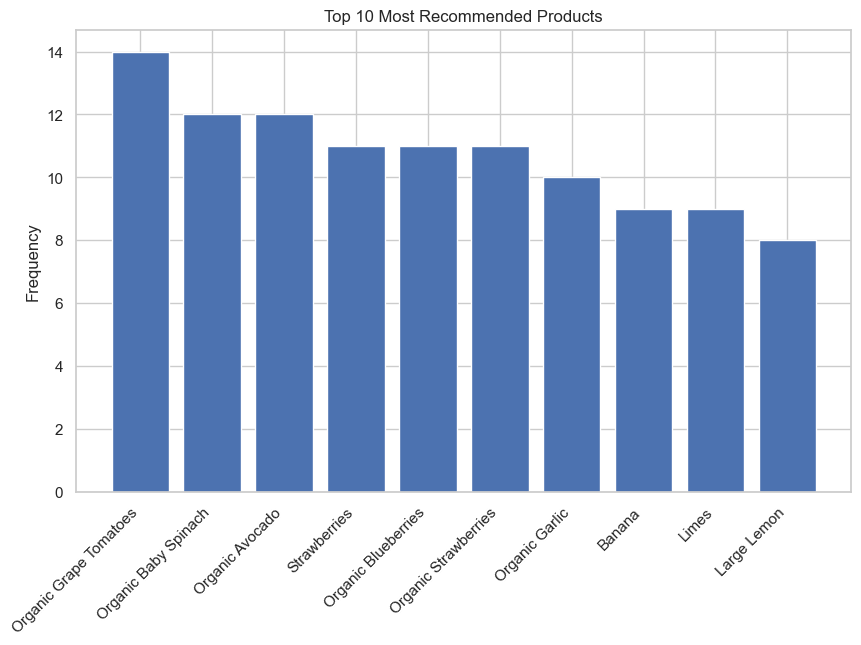


🛒 Top 10 Most Purchased Products in Dataset:
   product_id            product_name   count
0       24852                  Banana  472565
1       13176  Bag of Organic Bananas  379450
2       21137    Organic Strawberries  264683
3       21903    Organic Baby Spinach  241921
4       47209    Organic Hass Avocado  213584
5       47766         Organic Avocado  176815
6       47626             Large Lemon  152657
7       16797            Strawberries  142951
8       26209                   Limes  140627
9       27845      Organic Whole Milk  137905


In [53]:
import ast
import matplotlib.pyplot as plt
from collections import Counter

# Load product data
products = pd.read_csv("C:/Users/lenovo/Desktop/instacart-recommender-system/data/products.csv")

# Load recommendations
rec_df = pd.read_csv("user_product_recommendations.csv")

# Convert string lists back to Python lists
rec_df["recommended_products"] = rec_df["recommended_products"].apply(ast.literal_eval)

# Flatten all recommended products
all_recs = [prod for sublist in rec_df["recommended_products"] for prod in sublist]

# Count frequency
rec_counts = Counter(all_recs)

# Top 10 recommended products
top_recs = rec_counts.most_common(10)
print("🔝 Top 10 Recommended Products:")
for prod, cnt in top_recs:
    print(f"{prod}: {cnt} times")

# Visualization: Bar chart
plt.figure(figsize=(10,6))
plt.bar([x[0] for x in top_recs], [x[1] for x in top_recs])
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 Most Recommended Products")
plt.ylabel("Frequency")
plt.show()

# Compare with most purchased products historically
top_purchased = user_orders_prior["product_id"].value_counts().head(10).reset_index()
top_purchased.columns = ["product_id", "count"]

top_purchased = top_purchased.merge(products, on="product_id", how="left")

print("\n🛒 Top 10 Most Purchased Products in Dataset:")
print(top_purchased[["product_id", "product_name", "count"]])


## Step 4: Word Cloud of Recommended Products

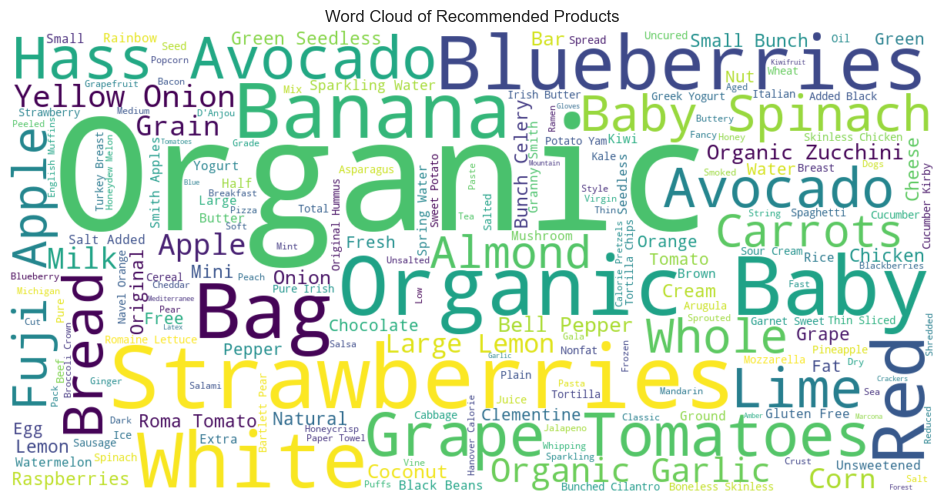

In [57]:
from wordcloud import WordCloud

# Create word cloud text
rec_text = " ".join(all_recs)

# Generate word cloud
wordcloud = WordCloud(width=1200, height=600, background_color="white").generate(rec_text)

# Plot
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Recommended Products")
plt.show()


In [ ]:
pip install wordcloud


In [56]:
from wordcloud import WordCloud


## Step 5: Bar chart of Top 20 Recommended Products

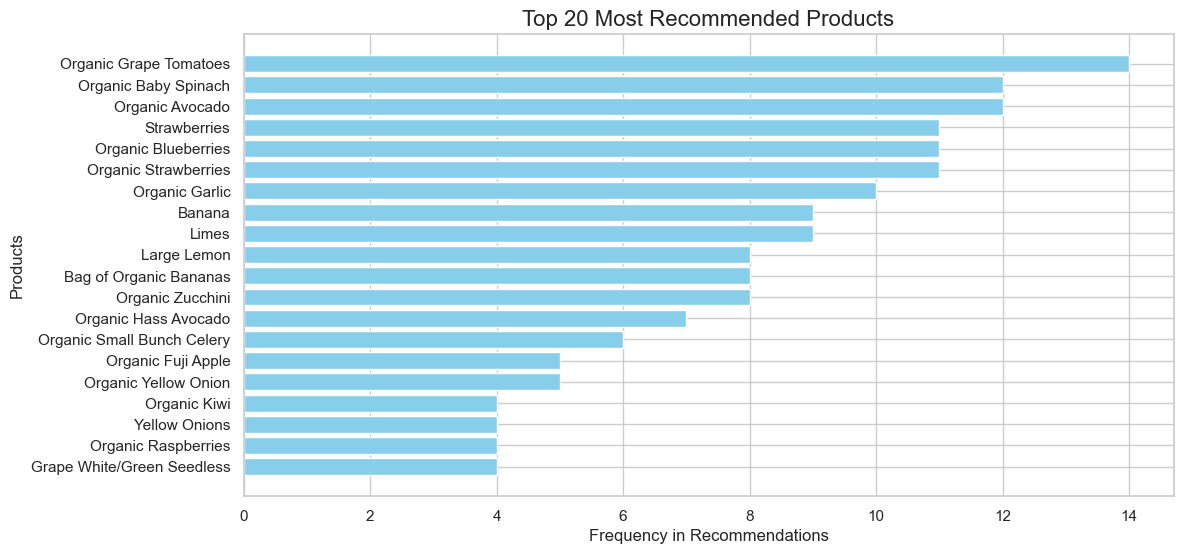

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import ast

# Load recommendations
recs_df = pd.read_csv("user_product_recommendations.csv")

# Convert string list to Python list
all_recs = []
for rec in recs_df["recommended_products"]:
    products = ast.literal_eval(rec)  # safely convert string to list
    all_recs.extend(products)

# Count product frequencies
product_counts = Counter(all_recs)

# Get Top 20 most recommended products
top_20 = product_counts.most_common(20)

# Separate product names and counts
products, counts = zip(*top_20)

# Plot bar chart
plt.figure(figsize=(12, 6))
plt.barh(products[::-1], counts[::-1], color="skyblue")
plt.title("Top 20 Most Recommended Products", fontsize=16)
plt.xlabel("Frequency in Recommendations")
plt.ylabel("Products")
plt.show()


## Pie Chart of Organic vs Non-Organic Products

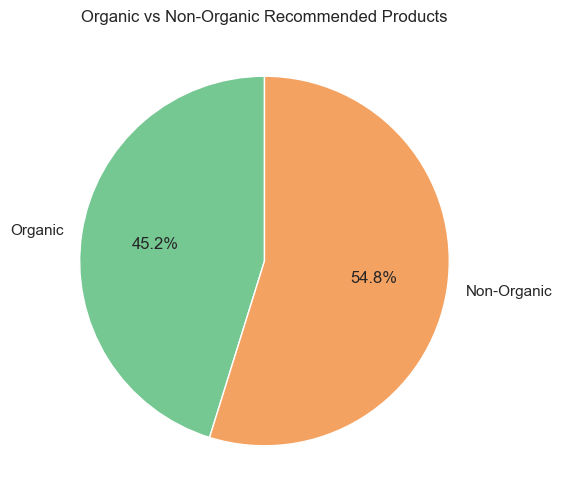

In [59]:
import pandas as pd
import ast
import matplotlib.pyplot as plt

# Load recommendations
recs_df = pd.read_csv("user_product_recommendations.csv")

# Convert string list to Python list
all_recs = []
for rec in recs_df["recommended_products"]:
    products = ast.literal_eval(rec)  # safely convert string to list
    all_recs.extend(products)

# Count organic vs non-organic
organic_count = sum(1 for p in all_recs if "Organic" in p)
non_organic_count = len(all_recs) - organic_count

# Pie chart
labels = ["Organic", "Non-Organic"]
sizes = [organic_count, non_organic_count]
colors = ["#76c893", "#f4a261"]

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90, colors=colors)
plt.title("Organic vs Non-Organic Recommended Products")
plt.show()


## time-based analysis of recommendations

this will show which products are bought more on weekdays vs weekends.

In [63]:
import os
print(os.getcwd())


c:\Users\lenovo\Desktop\instacart-recommender-system\notebooks


In [64]:
print(os.listdir())


['data_load_and_cleaning.ipynb', 'top_n_recommendations.csv', 'user_product_recommendations.csv', 'user_recommendations.csv']


In [66]:
orders = pd.read_csv("../data/orders.csv")
products = pd.read_csv("../data/products.csv")
aisles = pd.read_csv("../data/aisles.csv")


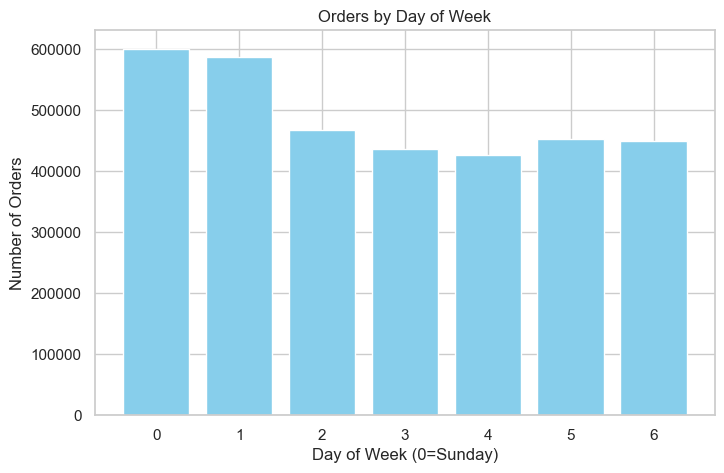

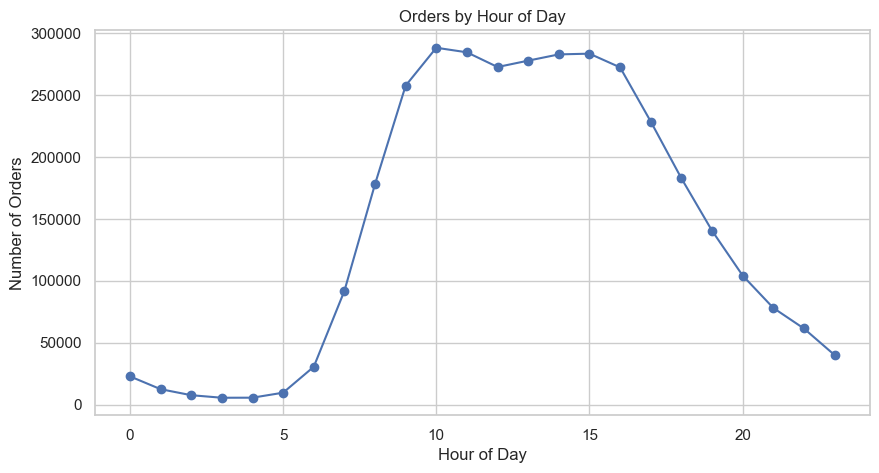

In [67]:
import matplotlib.pyplot as plt

# 1. Orders by Day of Week
dow_counts = orders["order_dow"].value_counts().sort_index()
plt.figure(figsize=(8,5))
plt.bar(dow_counts.index, dow_counts.values, color="skyblue")
plt.xlabel("Day of Week (0=Sunday)")
plt.ylabel("Number of Orders")
plt.title("Orders by Day of Week")
plt.show()

# 2. Orders by Hour of Day
hour_counts = orders["order_hour_of_day"].value_counts().sort_index()
plt.figure(figsize=(10,5))
plt.plot(hour_counts.index, hour_counts.values, marker="o")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Orders")
plt.title("Orders by Hour of Day")
plt.grid(True)
plt.show()


## visualizations + insights

# Step 1: Orders by Day & Hour (Customer Behavior)

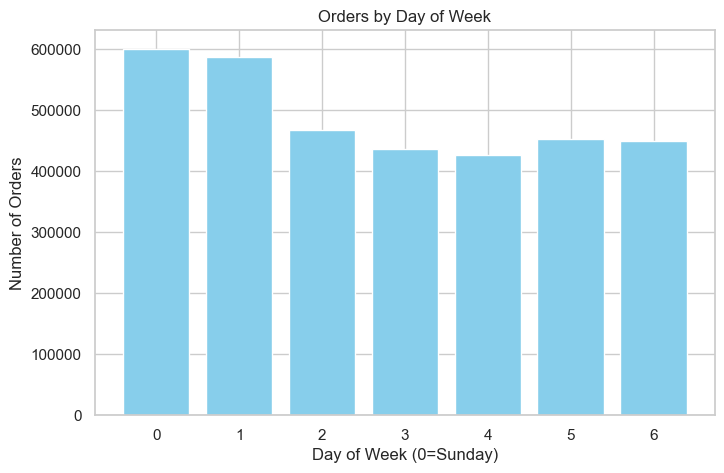

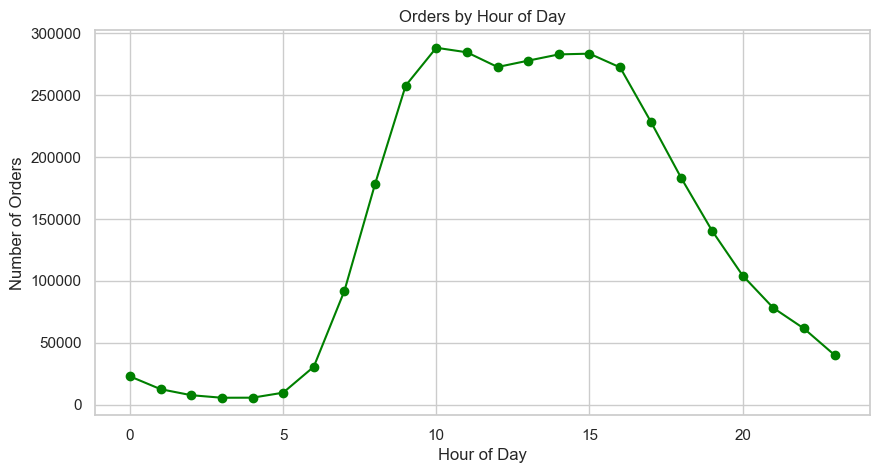

In [68]:
# Orders by Day of Week
dow_counts = orders["order_dow"].value_counts().sort_index()
plt.figure(figsize=(8,5))
plt.bar(dow_counts.index, dow_counts.values, color="skyblue")
plt.xlabel("Day of Week (0=Sunday)")
plt.ylabel("Number of Orders")
plt.title("Orders by Day of Week")
plt.show()

# Orders by Hour of Day
hour_counts = orders["order_hour_of_day"].value_counts().sort_index()
plt.figure(figsize=(10,5))
plt.plot(hour_counts.index, hour_counts.values, marker="o", color="green")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Orders")
plt.title("Orders by Hour of Day")
plt.grid(True)
plt.show()


# Step 2: Top Aisles Customers Buy From

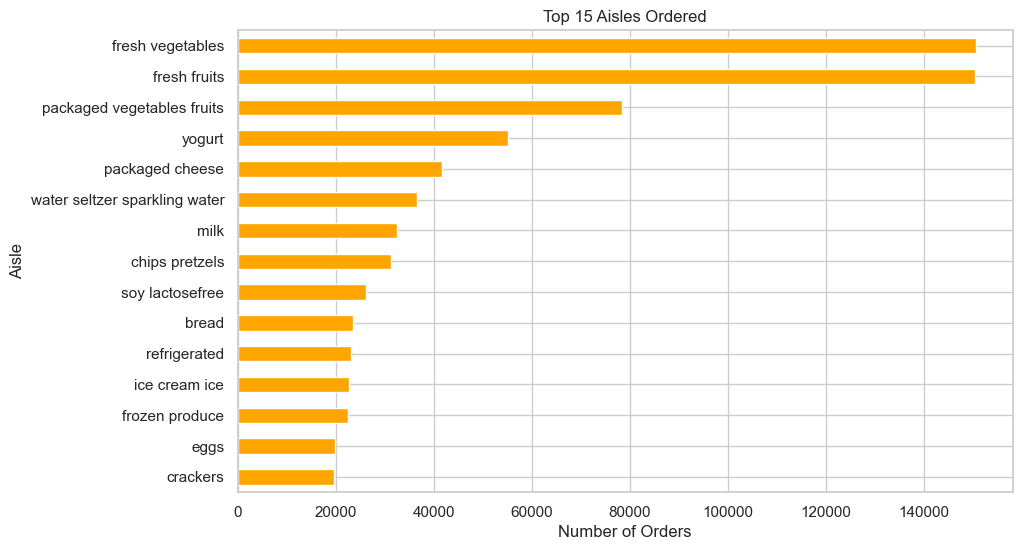

In [69]:
# Merge order_products and products to get aisle info
order_products = pd.read_csv("../data/order_products__train.csv")
aisles = pd.read_csv("../data/aisles.csv")

order_aisles = order_products.merge(products, on="product_id").merge(aisles, on="aisle_id")

top_aisles = order_aisles["aisle"].value_counts().head(15)

plt.figure(figsize=(10,6))
top_aisles.plot(kind="barh", color="orange")
plt.xlabel("Number of Orders")
plt.ylabel("Aisle")
plt.title("Top 15 Aisles Ordered")
plt.gca().invert_yaxis()
plt.show()


# Step 3: Reorder Ratio (Customer Loyalty)

In [70]:
# % of products reordered
reorder_ratio = order_products["reordered"].mean()
print(f"Reorder Ratio: {reorder_ratio:.2%}")


Reorder Ratio: 59.86%


# Step 4: Top Products Customers Reorder

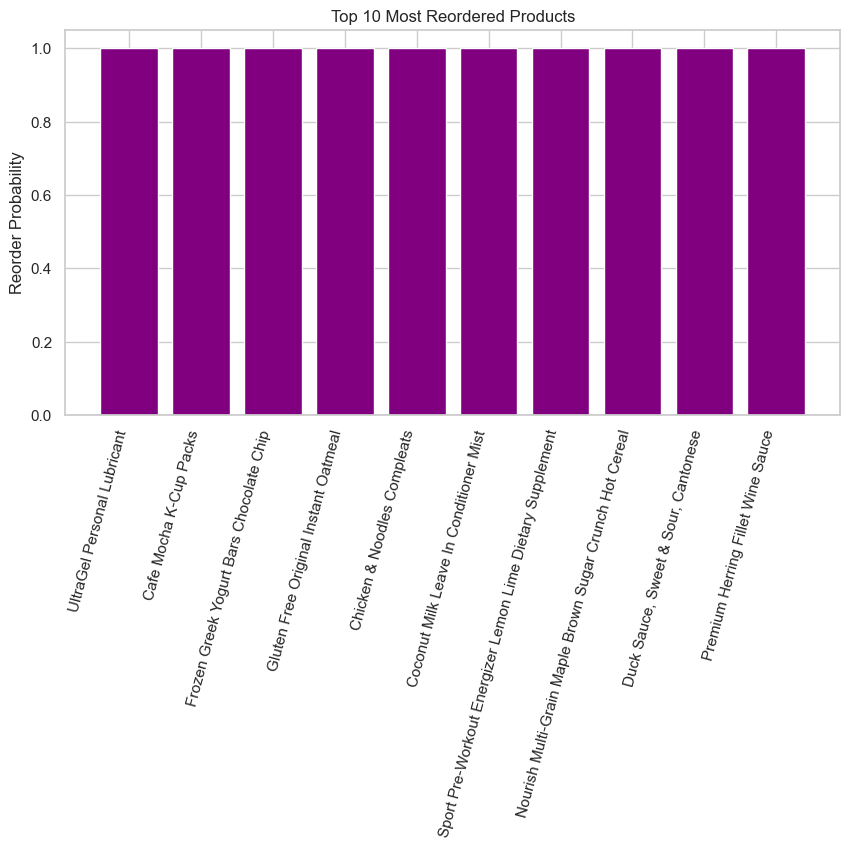

In [71]:
top_reordered = order_products.groupby("product_id")["reordered"].mean().sort_values(ascending=False).head(10)
top_reordered = top_reordered.reset_index().merge(products, on="product_id")

plt.figure(figsize=(10,5))
plt.bar(top_reordered["product_name"], top_reordered["reordered"], color="purple")
plt.xticks(rotation=75, ha="right")
plt.ylabel("Reorder Probability")
plt.title("Top 10 Most Reordered Products")
plt.show()


## End of all visulization

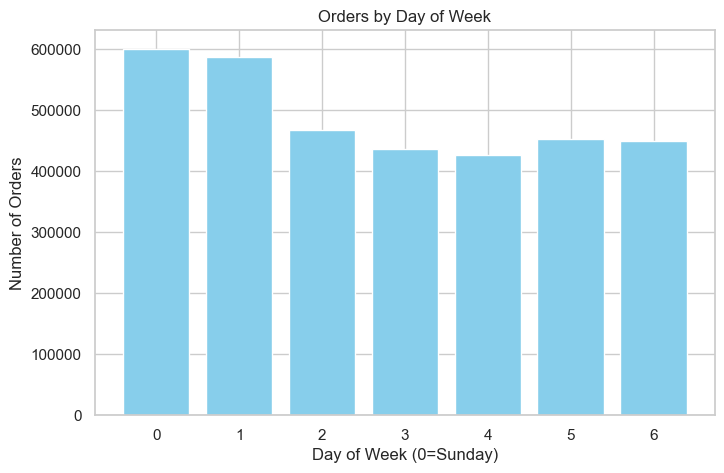

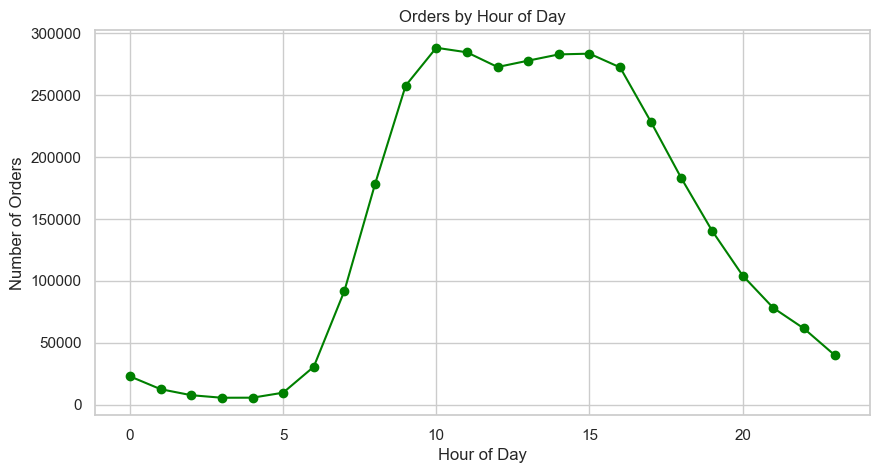

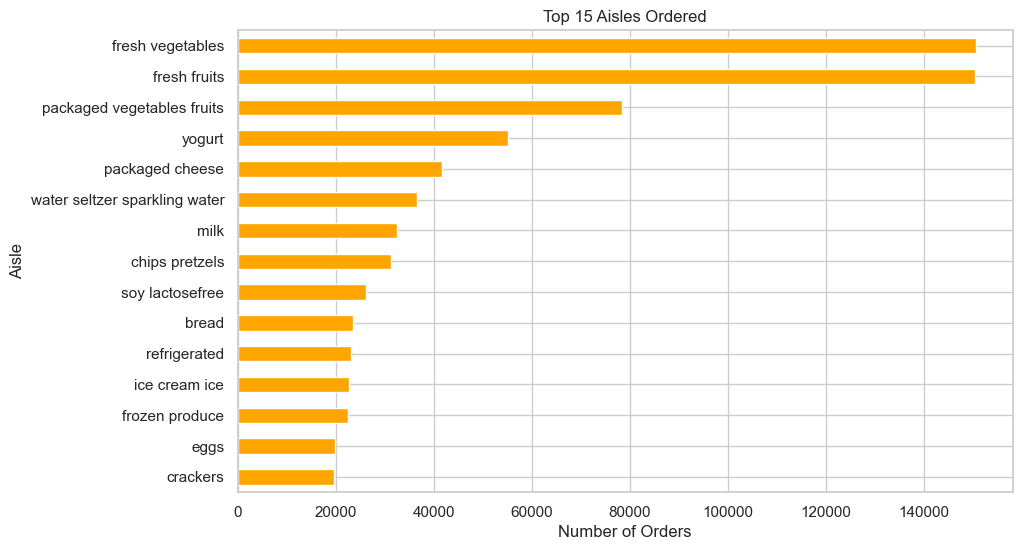

Reorder Ratio: 59.86%


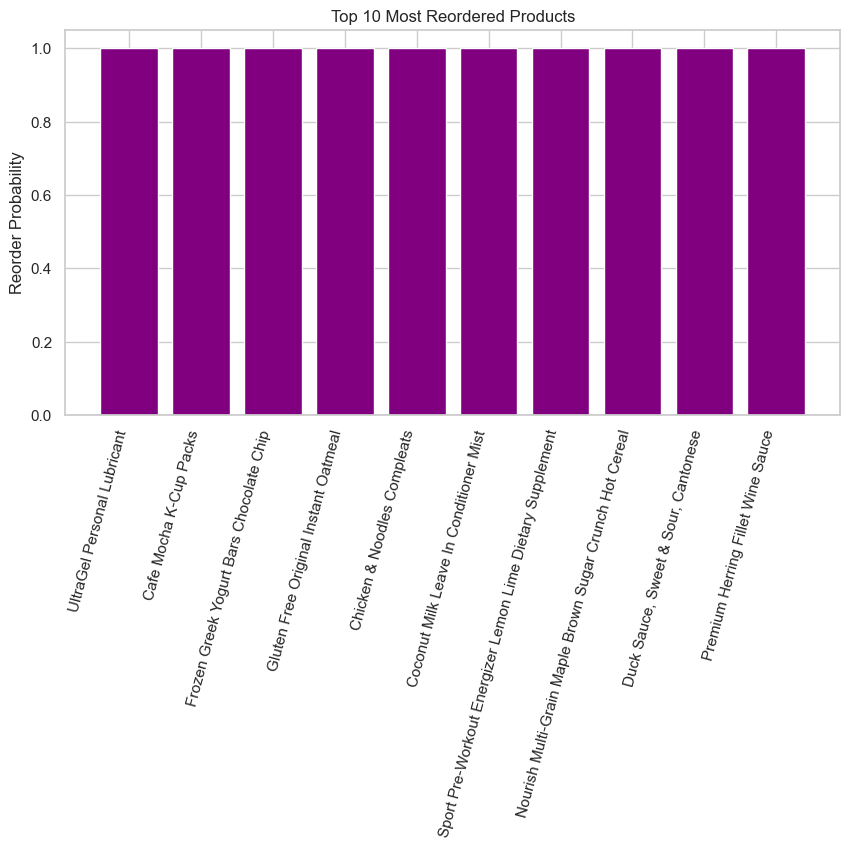

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

# ========== Orders by Day ==========
dow_counts = orders["order_dow"].value_counts().sort_index()
plt.figure(figsize=(8,5))
plt.bar(dow_counts.index, dow_counts.values, color="skyblue")
plt.xlabel("Day of Week (0=Sunday)")
plt.ylabel("Number of Orders")
plt.title("Orders by Day of Week")
plt.show()

# ========== Orders by Hour ==========
hour_counts = orders["order_hour_of_day"].value_counts().sort_index()
plt.figure(figsize=(10,5))
plt.plot(hour_counts.index, hour_counts.values, marker="o", color="green")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Orders")
plt.title("Orders by Hour of Day")
plt.grid(True)
plt.show()

# ========== Top 15 Aisles ==========
order_products = pd.read_csv("../data/order_products__train.csv")
aisles = pd.read_csv("../data/aisles.csv")

order_aisles = order_products.merge(products, on="product_id").merge(aisles, on="aisle_id")
top_aisles = order_aisles["aisle"].value_counts().head(15)

plt.figure(figsize=(10,6))
top_aisles.plot(kind="barh", color="orange")
plt.xlabel("Number of Orders")
plt.ylabel("Aisle")
plt.title("Top 15 Aisles Ordered")
plt.gca().invert_yaxis()
plt.show()

# ========== Reorder Ratio ==========
reorder_ratio = order_products["reordered"].mean()
print(f"Reorder Ratio: {reorder_ratio:.2%}")

# ========== Top 10 Reordered Products ==========
top_reordered = order_products.groupby("product_id")["reordered"].mean().sort_values(ascending=False).head(10)
top_reordered = top_reordered.reset_index().merge(products, on="product_id")

plt.figure(figsize=(10,5))
plt.bar(top_reordered["product_name"], top_reordered["reordered"], color="purple")
plt.xticks(rotation=75, ha="right")
plt.ylabel("Reorder Probability")
plt.title("Top 10 Most Reordered Products")
plt.show()
